## Unsupservised Clustering Analysis
### LUAD - Lung Adenocarcinoma Data

#### 1. Load Data

In [57]:
import pandas as pd

# Read the data
data = pd.read_csv('clinical_data.csv')

#### 2. Preprocess Data

In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define feature groups
CATEGORICAL_FEATURES = [
    'sex',          # binary
    'race',         # multi-class
    'smoking_status',# binary (smoker/non-smoker)
    'stage',        # ordinal (but treat as categorical given small number of categories)
    'egfr_mutated', # binary (pos/neg)
    'kras_mutated', # binary (pos/neg)
    'tp53_mutated'  # binary (pos/neg)
]

NUMERICAL_FEATURES = ['age']  # only continuous variable

# Initial cleaning
def clean_data(df):
    # Remove unnecessary columns
    columns_to_drop = ['patient_id', 'study_id', 'histology']
    df = df.drop(columns=columns_to_drop)

    # Drop rows with missing values
    df = df.dropna()
    
    # Store survival data separately
    survival_data = df[['survival_months', 'survival_status']]
    df = df.drop(columns=['survival_months', 'survival_status'])
    
    return df, survival_data

In [59]:
def preprocess_features(df):
    """
    Specific preprocessing for LUAD data features
    """
    df = df.copy()
    
    # Convert mutation status to binary
    mutation_columns = ['egfr_mutated', 'kras_mutated', 'tp53_mutated']
    for col in mutation_columns:
        df[col] = df[col].map({'pos': 1, 'neg': 0})
    
    # Convert stage to ordered categories
    # Remove 'stage_' prefix and convert to numeric
    df['stage'] = df['stage'].str.replace('stage_', '').astype(int)
    
    # Standardize smoking status
    df['smoking_status'] = df['smoking_status'].map({
        'smoker': 1,
        'non_smoker': 0
    })
    
    # Handle race encoding (focus on Asian vs Caucasian comparison)
    df['race'] = df['race'].map({
        'asian': 'asian',
        'caucasian': 'caucasian',
        'african_american': 'other'  # based on your research focus
    })
    
    return df

In [60]:
def create_preprocessing_pipeline():
    """
    Creates a preprocessing pipeline specific for LUAD data
    """
    # Categorical features preprocessing
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first', sparse_output=False))
    ])
    
    # Numerical features preprocessing
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    # Combine transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, NUMERICAL_FEATURES),
            ('cat', categorical_transformer, CATEGORICAL_FEATURES)
        ],
        remainder='drop'  # Drop any other columns
    )
    
    return preprocessor

In [61]:
def prepare_data_for_clustering(data_path):
    """
    Complete data preparation pipeline
    """
    # Load data
    df = pd.read_csv(data_path)
    
    # Basic cleaning
    df_cleaned, survival_data = clean_data(df)
    
    # Feature preprocessing
    df_preprocessed = preprocess_features(df_cleaned)
    
    # Create and fit preprocessing pipeline
    preprocessor = create_preprocessing_pipeline()
    X_processed = preprocessor.fit_transform(df_preprocessed)
    
    # Get feature names after transformation
    cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(CATEGORICAL_FEATURES)
    feature_names = np.concatenate([NUMERICAL_FEATURES, cat_features])
    
    return X_processed, feature_names, survival_data

In [62]:
# Use the pipeline
X_processed, feature_names, survival_data = prepare_data_for_clustering('clinical_data.csv')

# Print feature names to understand transformed data
print("Processed features:", feature_names)

# Basic checks
print("\nProcessed data shape:", X_processed.shape)
print("\nProcessed data overview:")
print(pd.DataFrame(X_processed, columns=feature_names).describe())

Processed features: ['age' 'sex_male' 'race_caucasian' 'race_other' 'race_nan'
 'smoking_status_1' 'stage_2' 'stage_3' 'stage_4']

Processed data shape: (877, 9)

Processed data overview:
                age    sex_male  race_caucasian  race_other    race_nan  \
count  8.770000e+02  877.000000      877.000000  877.000000  877.000000   
mean   2.511611e-16    0.413911        0.602052    0.051311    0.001140   
std    1.000571e+00    0.492814        0.489754    0.220758    0.033768   
min   -3.957638e+00    0.000000        0.000000    0.000000    0.000000   
25%   -5.747568e-01    0.000000        0.000000    0.000000    0.000000   
50%    1.217188e-01    0.000000        1.000000    0.000000    0.000000   
75%    7.186978e-01    1.000000        1.000000    0.000000    0.000000   
max    2.310642e+00    1.000000        1.000000    1.000000    1.000000   

       smoking_status_1     stage_2     stage_3     stage_4  
count        877.000000  877.000000  877.000000  877.000000  
mean        

#### 3. Optuna Hyperparameter Optimization

In [67]:
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster
import optuna

def objective_tsne_hc(trial, X, random_state=43):
    """
    Optuna objective function for t-SNE + Hierarchical clustering
    """
    # Parameter suggestions
    params = {
        # Perplexity: balanced for your dataset size
        "perplexity": trial.suggest_float("perplexity", 20.0, 50.0),
        
        # Learning rate: wider range for exploration
        "learning_rate": trial.suggest_float("learning_rate", 200.0, 1000.0),
        
        # Number of clusters: based on LUAD biology
        "n_clusters": trial.suggest_int("n_clusters", 3, 6)
    }
    
    try:
        # Perform t-SNE
        tsne = TSNE(
            n_components=2,
            perplexity=params["perplexity"],
            learning_rate=params["learning_rate"],
            random_state=random_state,
            max_iter=1000
        )
        tsne_embedding = tsne.fit_transform(X)
        
        # Hierarchical clustering
        linkage_matrix = linkage(tsne_embedding, method='ward')
        labels = fcluster(linkage_matrix, params["n_clusters"], criterion='maxclust')
        
        # Evaluate using silhouette score
        score = silhouette_score(tsne_embedding, labels)
        
        return score
        
    except Exception as e:
        print(f"Error in optimization: {e}")
        return float('-inf')

# Optimize the clustering pipeline
def optimize_clustering_tsne_hc(X, n_trials=10):
    study = optuna.create_study(direction="maximize")
    study.optimize(
        lambda trial: objective_tsne_hc(trial, X),
        n_trials=n_trials
    )
    
    return study.best_params, study.best_value

In [68]:
# Suppress optuna warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Run optimization
best_params_tsne, best_score_tsne = optimize_clustering_tsne_hc(X_processed, n_trials=10)

print("Best Parameters:")
print(f"Perplexity: {best_params_tsne['perplexity']:.2f}")
print(f"Learning Rate: {best_params_tsne['learning_rate']:.2f}")
print(f"Number of Clusters: {best_params_tsne['n_clusters']}")
print(f"\nBest Silhouette Score: {best_score_tsne:.3f}")

Best Parameters:
Perplexity: 25.45
Learning Rate: 404.55
Number of Clusters: 6

Best Silhouette Score: 0.477


In [70]:
# Run multiple times with different random seeds
def check_stability(X, best_params, n_runs=10):
    silhouette_scores = []
    cluster_sizes = []
    
    for seed in range(n_runs):
        tsne = TSNE(
            n_components=2,
            perplexity=best_params['perplexity'],
            learning_rate=best_params['learning_rate'],
            random_state=seed
        )
        embedding = tsne.fit_transform(X)
        
        linkage_matrix = linkage(embedding, method='ward')
        labels = fcluster(linkage_matrix, best_params['n_clusters'], criterion='maxclust')
        
        silhouette_scores.append(silhouette_score(embedding, labels))
        cluster_sizes.append(pd.Series(labels).value_counts())
    
    return silhouette_scores, cluster_sizes

# Check stability
silhouette_scores, cluster_sizes = check_stability(X_processed, best_params_tsne)

In [71]:
silhouette_scores = pd.Series(silhouette_scores)
cluster_sizes = pd.DataFrame(cluster_sizes).fillna(0)

print("Silhouette Scores:")
print(silhouette_scores.describe())

print("\nCluster Sizes:")
print(cluster_sizes.describe())

Silhouette Scores:
count    1.000000e+01
mean     4.767719e-01
std      6.282881e-08
min      4.767720e-01
25%      4.767720e-01
50%      4.767720e-01
75%      4.767720e-01
max      4.767720e-01
dtype: float64

Cluster Sizes:
           4      6      5      1      3     2
count   10.0   10.0   10.0   10.0   10.0  10.0
mean   214.0  180.0  175.0  129.0  112.0  67.0
std      0.0    0.0    0.0    0.0    0.0   0.0
min    214.0  180.0  175.0  129.0  112.0  67.0
25%    214.0  180.0  175.0  129.0  112.0  67.0
50%    214.0  180.0  175.0  129.0  112.0  67.0
75%    214.0  180.0  175.0  129.0  112.0  67.0
max    214.0  180.0  175.0  129.0  112.0  67.0


In [73]:
# Visualize clusters
import matplotlib.pyplot as plt
import seaborn as sns

def plot_clusters(embedding, labels, title="t-SNE Clustering"):
    # Create a DataFrame for plotting
    df_plot = pd.DataFrame({
        'x': embedding[:, 0],
        'y': embedding[:, 1],
        'Cluster': labels
    })
    
    # Plot clusters
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df_plot, x='x', y='y', hue='Cluster', palette='viridis', legend='full')
    plt.title(title)
    plt.show()

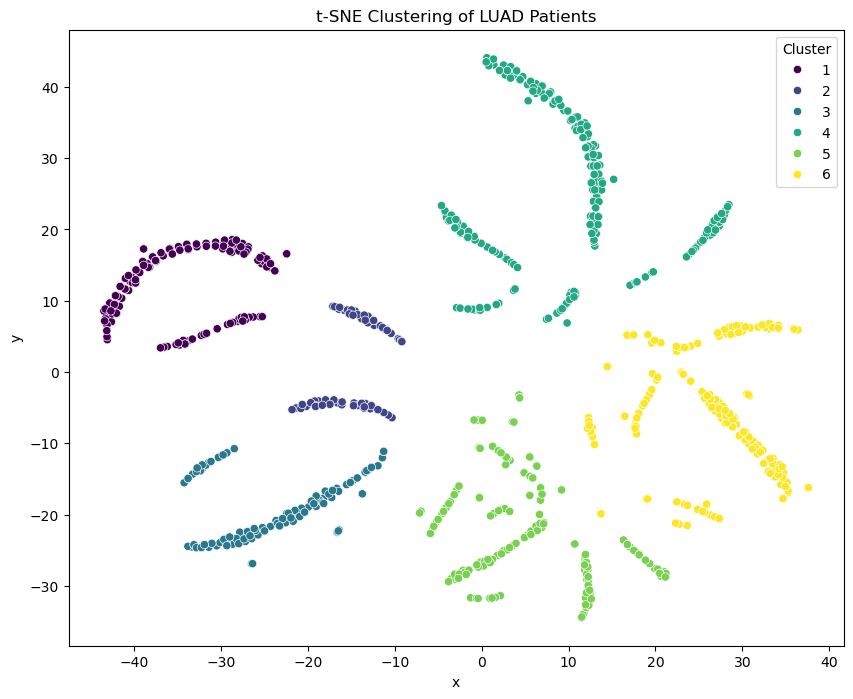

In [80]:
# clustering
tsne = TSNE(
    n_components=2, # 2D embedding
    perplexity=best_params_tsne['perplexity'], # best perplexity from optimization
    learning_rate=best_params_tsne['learning_rate'], # best learning rate from optimization
    random_state=43
)
embedding = tsne.fit_transform(X_processed)

linkage_matrix = linkage(embedding, method='ward')
labels = fcluster(linkage_matrix, best_params_tsne['n_clusters'], criterion='maxclust')

plot_clusters(embedding, labels, title="t-SNE Clustering of LUAD Patients")

Visual Pattern Analysis:
- The clusters show distinct curved or arc-like patterns ("manifolds")
- Clear spatial separation between most clusters
- Some clusters form multiple distinct sub-groups
- The arrangement suggests a continuous spectrum of molecular/clinical features


Cluster-Specific Observations:
- Cluster 4 (turquoise): Largest cluster (214 patients), forms multiple well-defined arcs
- Cluster 6 (yellow): Second largest (180 patients), shows a branching pattern
- Cluster 5 (light green): Forms scattered sub-groups
- Cluster 1 (purple): Forms two distinct curved structures
- Cluster 2 (dark blue): Small, compact grouping
- Cluster 3 (blue-green): Forms a curved structure in the lower portion


Pattern Interpretation:
- The arc-like patterns are common in t-SNE and often indicate gradual transitions in features
- The branching structures might represent evolutionary relationships between subtypes
- The presence of sub-groups within clusters suggests possible hierarchical relationships

In [84]:
def analyze_cluster_characteristics(labels, clinical_data):
    """
    Analyze clinical features distribution across clusters
    """
    print("Clinical Characteristics by Cluster:")
    print("-" * 50)
    
    for cluster in sorted(np.unique(labels)):
        mask = labels == cluster
        cluster_data = clinical_data[mask]
        n_patients = sum(mask)
        
        print(f"\nCluster {cluster} (n={n_patients}, {n_patients/len(labels):.1%} of patients)")
        print("-" * 30)
        
        # Stage distribution
        print("\nStage Distribution:")
        print(cluster_data['stage'].value_counts(normalize=True).to_frame().round(3) * 100)
        
        # Smoking status
        print("\nSmoking Status:")
        print(cluster_data['smoking_status'].value_counts(normalize=True).to_frame().round(3) * 100)
        
        # Race distribution
        print("\nRace Distribution:")
        print(cluster_data['race'].value_counts(normalize=True).to_frame().round(3) * 100)
        
        # Age statistics
        print(f"\nAge Statistics:")
        print(f"Mean: {cluster_data['age'].mean():.1f}")
        print(f"Median: {cluster_data['age'].median():.1f}")
        print(f"Range: {cluster_data['age'].min():.1f} - {cluster_data['age'].max():.1f}")

# Run the analysis
clinical_features = [
    'sex', 
    'age',
    'race',
    'smoking_status',
    'stage',
    'egfr_mutated',
    'kras_mutated',
    'tp53_mutated'
]

df, survival_data = clean_data(data)
clinical_data = df[clinical_features]
analyze_cluster_characteristics(labels, clinical_data)

Clinical Characteristics by Cluster:
--------------------------------------------------

Cluster 1 (n=129, 14.7% of patients)
------------------------------

Stage Distribution:
         proportion
stage              
stage_1        75.2
stage_3        22.5
stage_4         2.3

Smoking Status:
                proportion
smoking_status            
smoker               100.0

Race Distribution:
           proportion
race                 
caucasian       100.0

Age Statistics:
Mean: 66.5
Median: 68.0
Range: 42.0 - 87.0

Cluster 2 (n=67, 7.6% of patients)
------------------------------

Stage Distribution:
         proportion
stage              
stage_2       100.0

Smoking Status:
                proportion
smoking_status            
smoker               100.0

Race Distribution:
           proportion
race                 
caucasian       100.0

Age Statistics:
Mean: 65.6
Median: 67.0
Range: 45.0 - 84.0

Cluster 3 (n=112, 12.8% of patients)
------------------------------

Stage Distributi

/var/folders/y9/vp7z2q9s3y11844f5h2_k4pw0000gn/T/ipykernel_11858/466006347.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot(age_data, labels=[f'Cluster {c}' for c in clusters])


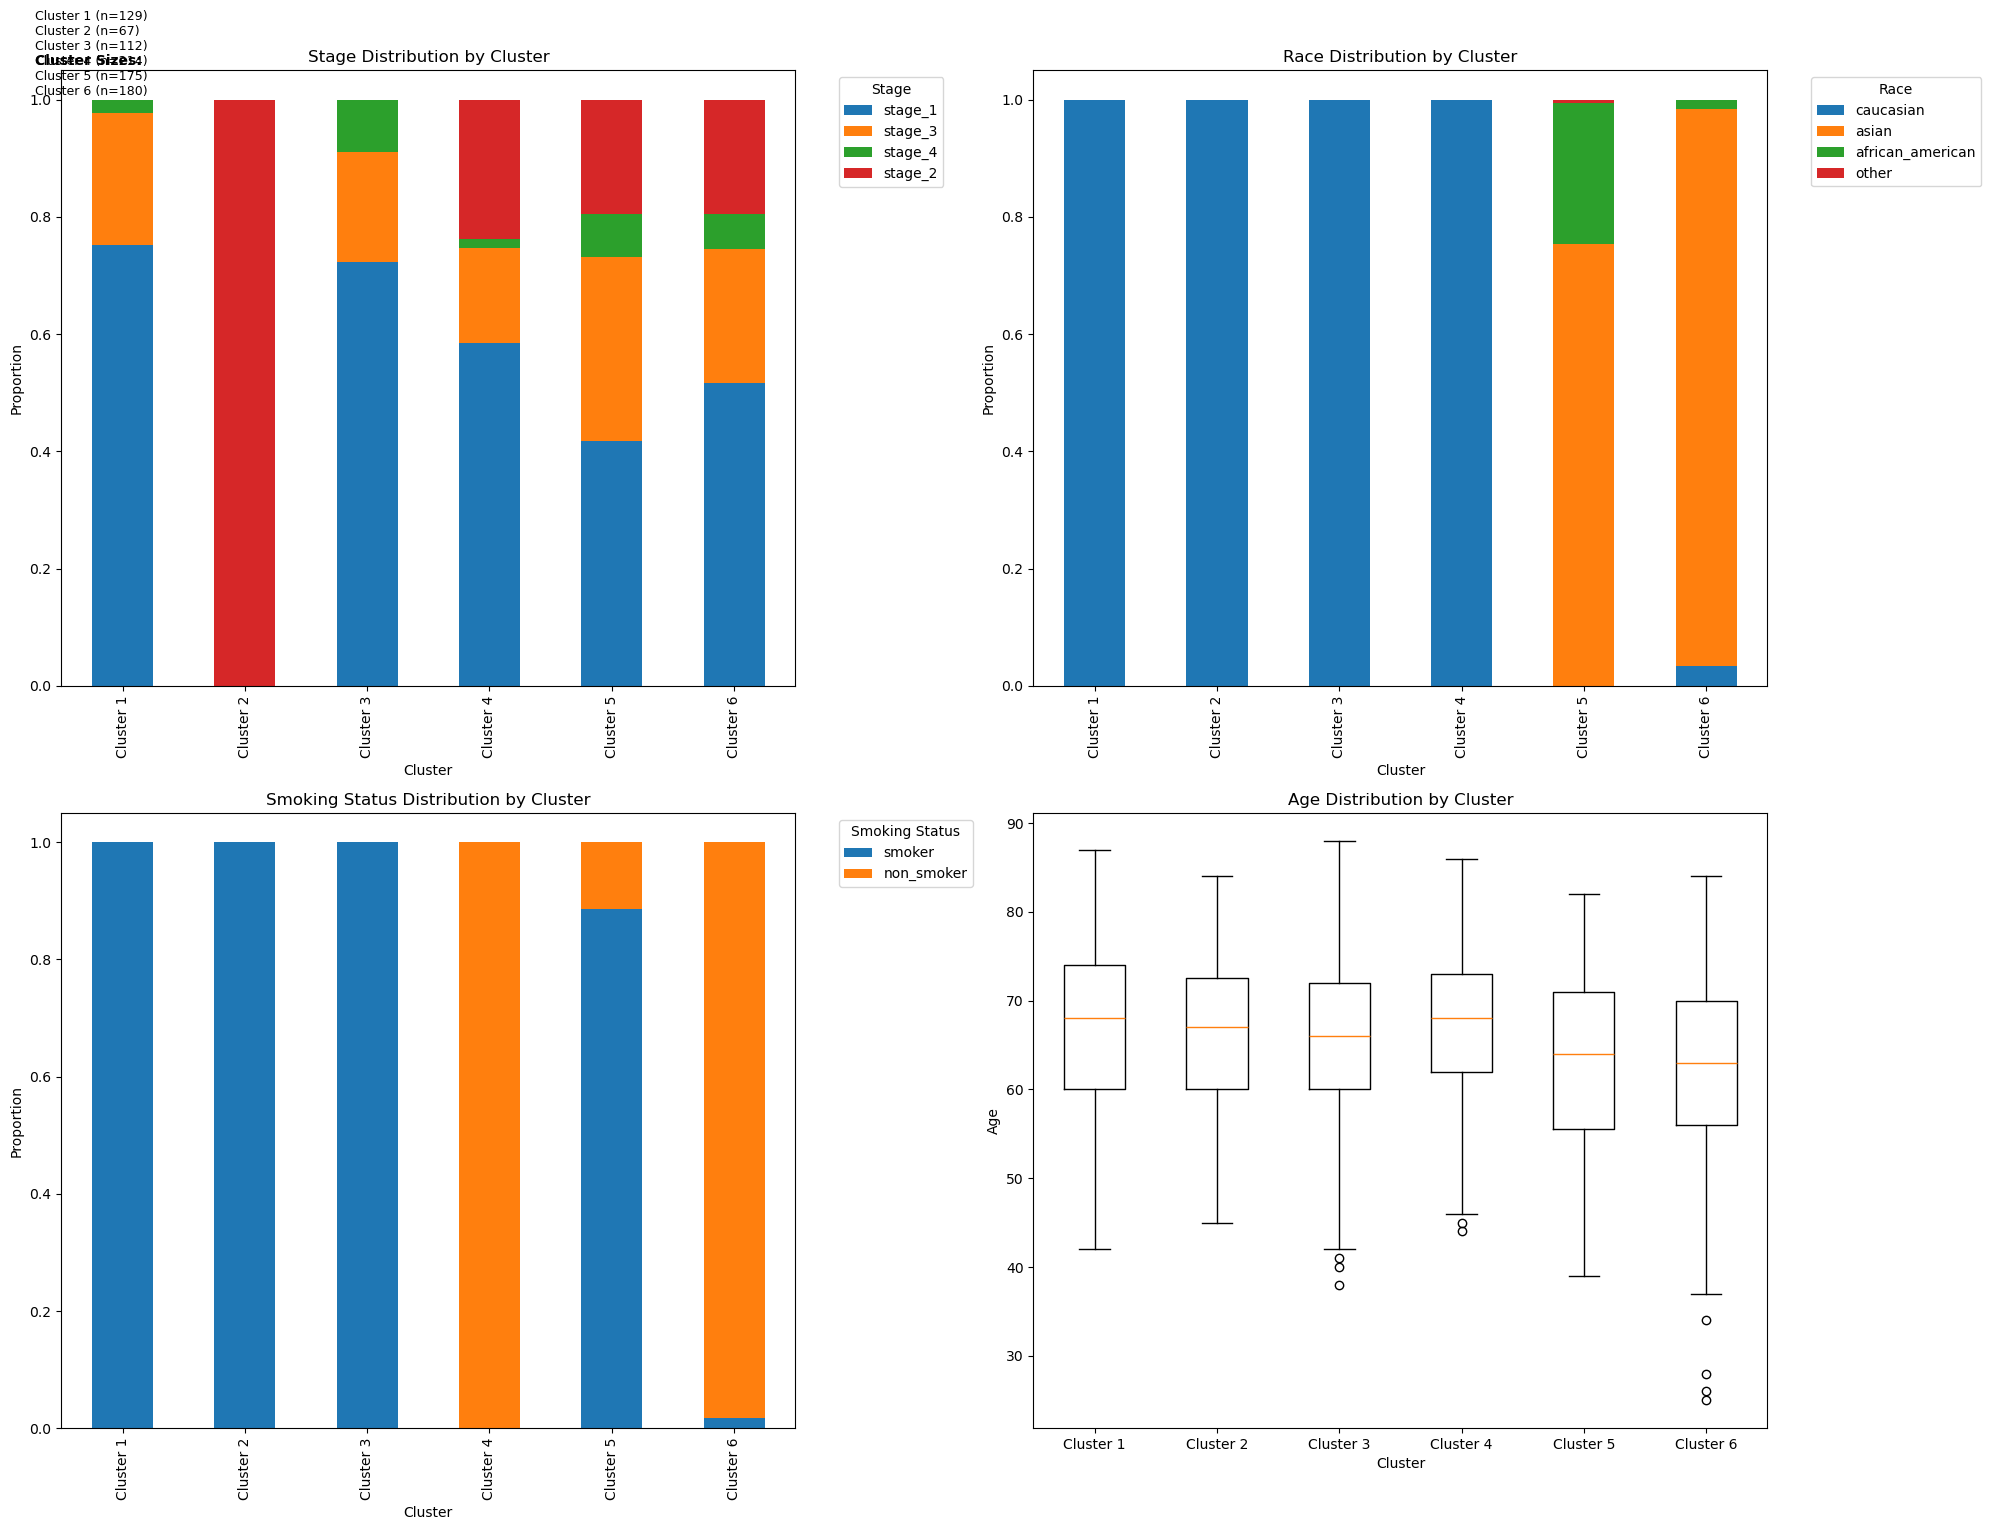

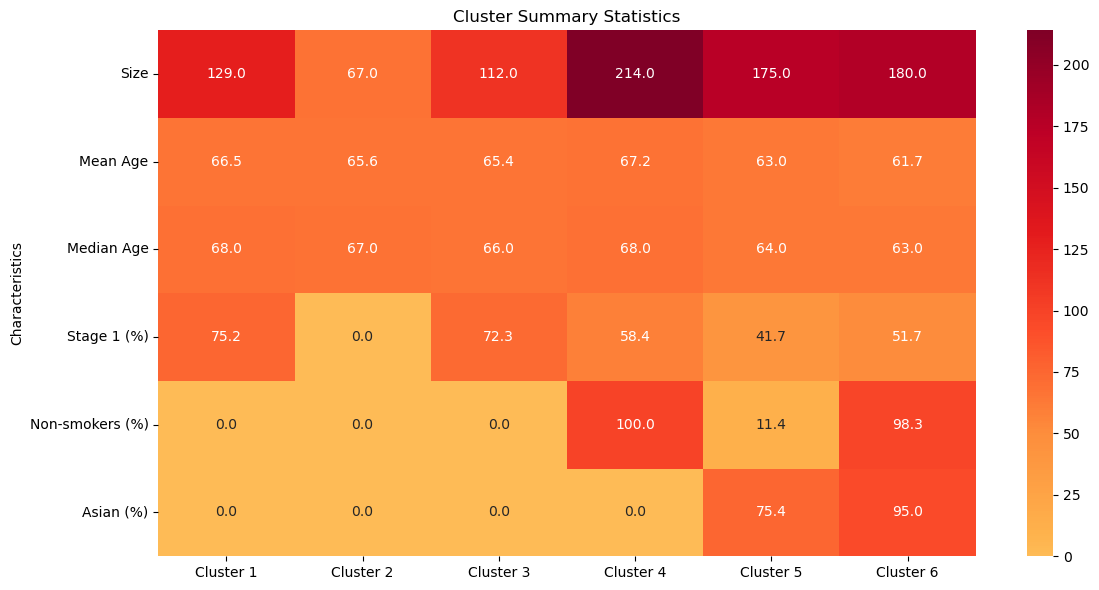

In [94]:
def visualize_cluster_characteristics(labels, clinical_data):
    """
    Create visualizations for clinical characteristics across clusters
    """
    clusters = sorted(np.unique(labels))
    n_clusters = len(clusters)
    
    # Set up the main figure with subplots
    fig = plt.figure(figsize=(20, 15))
    gs = plt.GridSpec(2, 2, figure=fig)
    
    # 1. Stage Distribution
    ax1 = fig.add_subplot(gs[0, 0])
    stage_data = []
    for cluster in clusters:
        mask = labels == cluster
        stage_dist = clinical_data[mask]['stage'].value_counts(normalize=True)
        stage_data.append(stage_dist)
    
    stage_df = pd.DataFrame(stage_data, index=[f'Cluster {c}' for c in clusters])
    stage_df.plot(kind='bar', stacked=True, ax=ax1)
    ax1.set_title('Stage Distribution by Cluster')
    ax1.set_xlabel('Cluster')
    ax1.set_ylabel('Proportion')
    ax1.legend(title='Stage', bbox_to_anchor=(1.05, 1))
    
    # 2. Race Distribution
    ax2 = fig.add_subplot(gs[0, 1])
    race_data = []
    for cluster in clusters:
        mask = labels == cluster
        race_dist = clinical_data[mask]['race'].value_counts(normalize=True)
        race_data.append(race_dist)
    
    race_df = pd.DataFrame(race_data, index=[f'Cluster {c}' for c in clusters])
    race_df.plot(kind='bar', stacked=True, ax=ax2)
    ax2.set_title('Race Distribution by Cluster')
    ax2.set_xlabel('Cluster')
    ax2.set_ylabel('Proportion')
    ax2.legend(title='Race', bbox_to_anchor=(1.05, 1))
    
    # 3. Smoking Status
    ax3 = fig.add_subplot(gs[1, 0])
    smoking_data = []
    for cluster in clusters:
        mask = labels == cluster
        smoking_dist = clinical_data[mask]['smoking_status'].value_counts(normalize=True)
        smoking_data.append(smoking_dist)
    
    smoking_df = pd.DataFrame(smoking_data, index=[f'Cluster {c}' for c in clusters])
    smoking_df.plot(kind='bar', stacked=True, ax=ax3)
    ax3.set_title('Smoking Status Distribution by Cluster')
    ax3.set_xlabel('Cluster')
    ax3.set_ylabel('Proportion')
    ax3.legend(title='Smoking Status', bbox_to_anchor=(1.05, 1))
    
    # 4. Age Distribution
    ax4 = fig.add_subplot(gs[1, 1])
    age_data = []
    for cluster in clusters:
        mask = labels == cluster
        age_data.append(clinical_data[mask]['age'])
    
    ax4.boxplot(age_data, labels=[f'Cluster {c}' for c in clusters])
    ax4.set_title('Age Distribution by Cluster')
    ax4.set_xlabel('Cluster')
    ax4.set_ylabel('Age')
    
    # Add cluster sizes
    cluster_sizes = []
    for cluster in clusters:
        mask = labels == cluster
        cluster_sizes.append(f"Cluster {cluster} (n={sum(mask)})")
    
    plt.figtext(0.02, 0.98, 'Cluster Sizes:', fontsize=10, fontweight='bold')
    plt.figtext(0.02, 0.96, '\n'.join(cluster_sizes), fontsize=9)
    
    plt.tight_layout()
    plt.show()

    # Create additional summary statistics figure
    plt.figure(figsize=(12, 6))
    cluster_stats = pd.DataFrame()
    
    for cluster in clusters:
        mask = labels == cluster
        cluster_data = clinical_data[mask]
        
        stats = {
            'Size': sum(mask),
            'Mean Age': cluster_data['age'].mean(),
            'Median Age': cluster_data['age'].median(),
            'Stage 1 (%)': (cluster_data['stage'] == 'stage_1').mean() * 100,
            'Non-smokers (%)': (cluster_data['smoking_status'] == 'non_smoker').mean() * 100,
            'Asian (%)': (cluster_data['race'] == 'asian').mean() * 100
        }
        
        cluster_stats[f'Cluster {cluster}'] = pd.Series(stats)
    
    sns.heatmap(cluster_stats, annot=True, fmt='.1f', cmap='YlOrRd', center=50)
    plt.title('Cluster Summary Statistics')
    plt.ylabel('Characteristics')
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_cluster_characteristics(labels, clinical_data)

# Cluster Characteristics Table (T-SNE Clustering)

| **Cluster** | **Size (% of total)** | **Population Characteristics**                                                                                   | **Key Features**                                                                                          |
|-------------|------------------------|-------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------|
| **Cluster 4** | Largest, 24.4%         | - Pure non-smoker Caucasian population<br>- Older population (median age 68)                                      | - Predominantly early-stage (58.4% stage 1)<br>- Represents "Classic Caucasian Non-Smoker LUAD" subtype    |
| **Cluster 6** | 20.5%                  | - Predominantly Asian (95%) and non-smoker (98.3%)<br>- Youngest population (median age 63, range starting at 25) | - Mixed stage distribution (51.7% stage 1)<br>- Likely represents "East Asian Never-Smoker LUAD" subtype  |
| **Cluster 5** | 20.0%                  | - Mixed Asian (75.4%) and African American (24%)<br>- Predominantly smokers (88.6%)                              | - More advanced disease (only 41.7% stage 1)<br>- Possible "Asian/African American Smoker" subtype        |
| **Cluster 1** | 14.7%                  | - Pure Caucasian smoker population<br>- Older population (median age 68)                                         | - Good stage distribution (75.2% stage 1)<br>- Might represent "Classical Smoking-Associated LUAD"        |
| **Cluster 3** | 12.8%                  | - Pure Caucasian smoker population<br>- Similar age profile to Cluster 1                                         | - Good stage distribution (72.3% stage 1)<br>- Could be a molecular variant of Cluster 1                  |
| **Cluster 2** | Smallest, 7.6%         | - Pure Caucasian smoker population<br>- Similar age profile to other Caucasian clusters                          | - Uniquely all stage 2<br>- Represents a distinct stage-specific subgroup                                 |


Key Patterns:

Clear Ethnic Stratification:
- Clusters 1-4: Pure Caucasian
- Clusters 5-6: Predominantly Asian


Smoking Status Segregation:
- Clusters 1,2,3: Pure smokers
- Clusters 4,6: Almost pure non-smokers
- Cluster 5: Mixed, predominantly smokers


Age Differences:
- Asian-dominated clusters (5,6) tend to be younger
- Caucasian clusters tend to be older

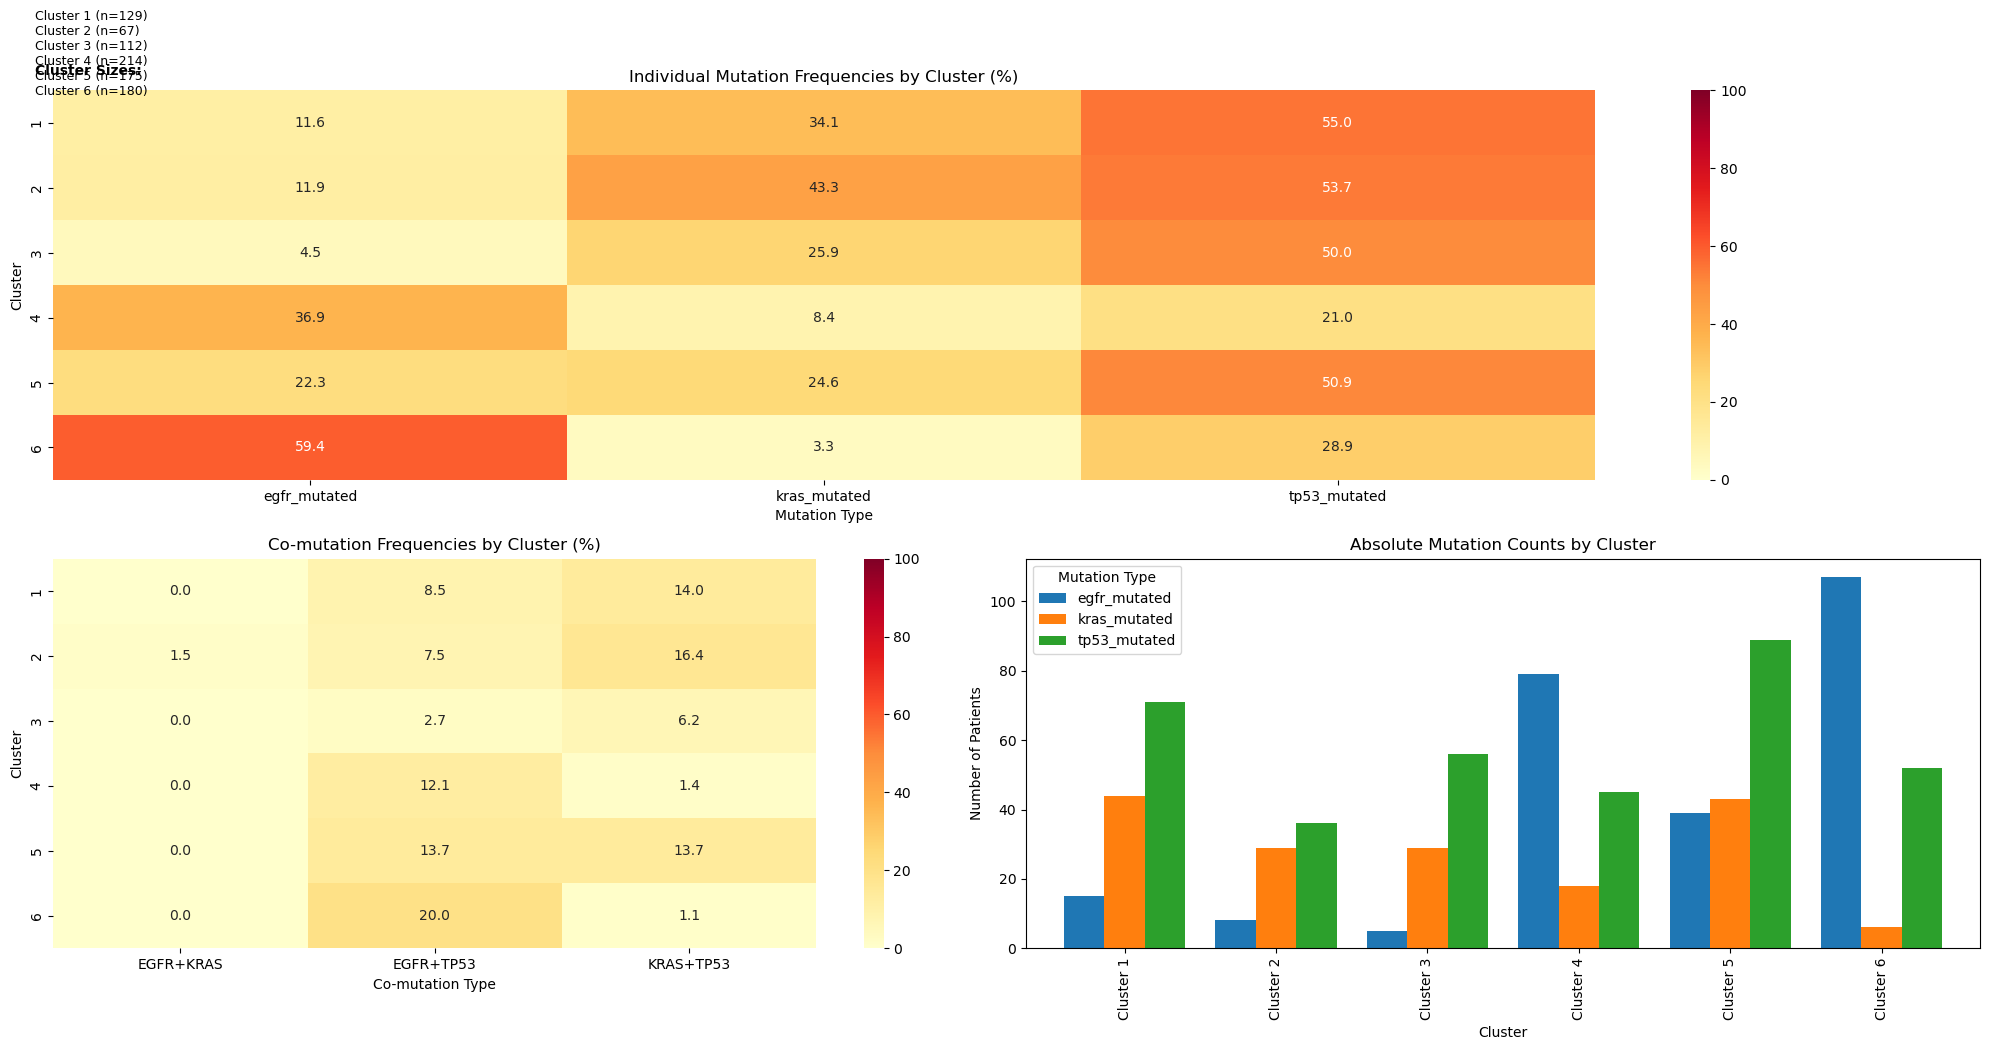


Mutation Pattern Summary:
--------------------------------------------------

Individual Mutation Frequencies (%)
   egfr_mutated  kras_mutated  tp53_mutated
1          11.6          34.1          55.0
2          11.9          43.3          53.7
3           4.5          25.9          50.0
4          36.9           8.4          21.0
5          22.3          24.6          50.9
6          59.4           3.3          28.9

Co-mutation Frequencies (%)
   EGFR+KRAS  EGFR+TP53  KRAS+TP53
1        0.0        8.5       14.0
2        1.5        7.5       16.4
3        0.0        2.7        6.2
4        0.0       12.1        1.4
5        0.0       13.7       13.7
6        0.0       20.0        1.1


In [95]:
def visualize_molecular_patterns(labels, data):
   """
   Create visualizations for molecular patterns and co-mutations across clusters
   """
   # Create a copy of data to avoid modifying original
   df = data.copy()
   
   # Convert mutation status to binary (0/1)
   mutation_cols = ['egfr_mutated', 'kras_mutated', 'tp53_mutated']
   for col in mutation_cols:
       gene = col.split('_')[0]
       df[col] = np.where(df[col] == f'{gene}_pos', 1, 0)
   
   clusters = sorted(np.unique(labels))
   
   # Set up the figure
   fig = plt.figure(figsize=(20, 10))
   gs = plt.GridSpec(2, 2)
   
   # 1. Individual Mutation Frequencies Heatmap
   ax1 = fig.add_subplot(gs[0, :])
   
   # Calculate mutation frequencies
   mutation_freq = pd.DataFrame(index=clusters, columns=mutation_cols, dtype=float)
   for cluster in clusters:
       mask = labels == cluster
       cluster_data = df[mask]
       for mutation in mutation_cols:
           mutation_freq.loc[cluster, mutation] = cluster_data[mutation].mean() * 100
   
   # Create heatmap for individual mutations
   sns.heatmap(mutation_freq, 
               annot=True, 
               fmt='.1f', 
               cmap='YlOrRd',
               vmin=0, 
               vmax=100,
               ax=ax1)
   ax1.set_title('Individual Mutation Frequencies by Cluster (%)')
   ax1.set_ylabel('Cluster')
   ax1.set_xlabel('Mutation Type')
   
   # 2. Co-mutation Frequencies Heatmap
   ax2 = fig.add_subplot(gs[1, 0])
   
   # Calculate co-mutation frequencies
   comut_cols = ['EGFR+KRAS', 'EGFR+TP53', 'KRAS+TP53']
   comut_freq = pd.DataFrame(index=clusters, columns=comut_cols, dtype=float)
   
   for cluster in clusters:
       mask = labels == cluster
       cluster_data = df[mask]
       
       comut_freq.loc[cluster, 'EGFR+KRAS'] = (cluster_data['egfr_mutated'] & 
                                              cluster_data['kras_mutated']).mean() * 100
       comut_freq.loc[cluster, 'EGFR+TP53'] = (cluster_data['egfr_mutated'] & 
                                              cluster_data['tp53_mutated']).mean() * 100
       comut_freq.loc[cluster, 'KRAS+TP53'] = (cluster_data['kras_mutated'] & 
                                              cluster_data['tp53_mutated']).mean() * 100
   
   sns.heatmap(comut_freq, 
               annot=True, 
               fmt='.1f', 
               cmap='YlOrRd',
               vmin=0, 
               vmax=100,
               ax=ax2)
   ax2.set_title('Co-mutation Frequencies by Cluster (%)')
   ax2.set_ylabel('Cluster')
   ax2.set_xlabel('Co-mutation Type')
   
   # 3. Mutation Distribution Barplot
   ax3 = fig.add_subplot(gs[1, 1])
   
   # Calculate cluster sizes and mutation counts
   cluster_stats = []
   for cluster in clusters:
       mask = labels == cluster
       cluster_data = df[mask]
       n_patients = sum(mask)
       
       stats = {'Cluster': f'Cluster {cluster}',
               'Size': n_patients}
       
       for mutation in mutation_cols:
           stats[mutation] = cluster_data[mutation].sum()
           
       cluster_stats.append(stats)
   
   cluster_stats_df = pd.DataFrame(cluster_stats)
   cluster_stats_df.set_index('Cluster')[mutation_cols].plot(
       kind='bar', 
       ax=ax3,
       width=0.8
   )
   ax3.set_title('Absolute Mutation Counts by Cluster')
   ax3.set_ylabel('Number of Patients')
   ax3.legend(title='Mutation Type')
   
   # Add cluster sizes annotation
   cluster_sizes = [f"Cluster {c} (n={sum(labels == c)})" for c in clusters]
   plt.figtext(0.02, 0.98, 'Cluster Sizes:', fontsize=10, fontweight='bold')
   plt.figtext(0.02, 0.96, '\n'.join(cluster_sizes), fontsize=9)
   
   plt.tight_layout()
   plt.show()
   
   return mutation_freq, comut_freq

# Run the visualization
df, survival_data = clean_data(data)
mutation_freq, comut_freq = visualize_molecular_patterns(labels, df)

# Print summary statistics
print("\nMutation Pattern Summary:")
print("-" * 50)
print("\nIndividual Mutation Frequencies (%)")
print(mutation_freq.round(1))
print("\nCo-mutation Frequencies (%)")
print(comut_freq.round(1))

# Cluster Analysis Table (Molecular Profiles)

| **Cluster** | **Size (% of total)** | **Molecular Profile**                                                                 | **Clinical Context**                                                                                                         |
|-------------|------------------------|---------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------|
| **Cluster 6** | n=180 (20.5%)         | - Highest EGFR mutation rate (59.4%)<br>- Lowest KRAS mutation rate (3.3%)<br>- Moderate TP53 rate (28.9%)                | - 95% Asian population<br>- 98.3% non-smokers<br>- Classic "Asian Non-Smoker EGFR-Mutant LUAD"<br>- Matches known literature |
| **Cluster 4** | n=214 (24.4%)         | - High EGFR mutation rate (36.9%)<br>- Low KRAS rate (8.4%)<br>- Lowest TP53 rate (21.0%)                                 | - 100% Caucasian<br>- 100% non-smokers<br>- Represents "Caucasian Non-Smoker EGFR-Mutant LUAD"                              |
| **Cluster 2** | n=67 (7.6%)           | - Low EGFR rate (11.9%)<br>- High KRAS rate (43.3%)<br>- High TP53 rate (53.7%)                                          | - 100% Caucasian smokers<br>- All stage 2 disease<br>- Classic "Smoking-Associated LUAD" pattern                            |
| **Clusters 1 & 3** | n=129, n=112       | - Low EGFR rates (11.6%, 4.5%)<br>- Moderate-high KRAS rates (34.1%, 25.9%)<br>- High TP53 rates (55.0%, 50.0%)         | - Both 100% Caucasian smokers<br>- May represent subtypes of smoking-associated LUAD                                        |
| **Cluster 5** | n=175 (20.0%)         | - Moderate EGFR rate (22.3%)<br>- Moderate KRAS rate (24.6%)<br>- High TP53 rate (50.9%)                                 | - Mixed Asian (75.4%) and African American (24%)<br>- Predominantly smokers (88.6%)<br>- Most heterogeneous cluster         |


Key Patterns and Implications:

EGFR-KRAS Mutual Exclusivity:
- Clear inverse relationship between EGFR and KRAS mutations
- Highest EGFR clusters have lowest KRAS rates and vice versa
- Consistent with known biology of LUAD


Smoking-Mutation Associations:
- Non-smoking clusters (4,6) show high EGFR, low KRAS
- Smoking clusters (1,2,3) show low EGFR, high KRAS
- Validates known smoking-mutation relationships


Ethnic Differences:
- Asian-dominated clusters show higher EGFR mutation rates
- Caucasian smoking clusters show higher KRAS rates
- Supports ethnic differences in LUAD molecular profiles


Survival Analysis Results:
--------------------------------------------------

Multivariate Logrank Test:
p-value: 0.0000

Median Survival Times (months):
------------------------------
Cluster 1: 56.7
Cluster 2: 34.4
Cluster 3: 41.4
Cluster 4: 167.0
Cluster 5: 70.6
Cluster 6: inf

Pairwise Logrank Tests:
------------------------------
Clusters 1 vs 2: p = 0.0174
Clusters 1 vs 4: p = 0.0063
Clusters 1 vs 6: p = 0.0018
Clusters 2 vs 4: p = 0.0000
Clusters 2 vs 5: p = 0.0046
Clusters 2 vs 6: p = 0.0000
Clusters 3 vs 4: p = 0.0001
Clusters 3 vs 6: p = 0.0000
Clusters 4 vs 5: p = 0.0322
Clusters 5 vs 6: p = 0.0073


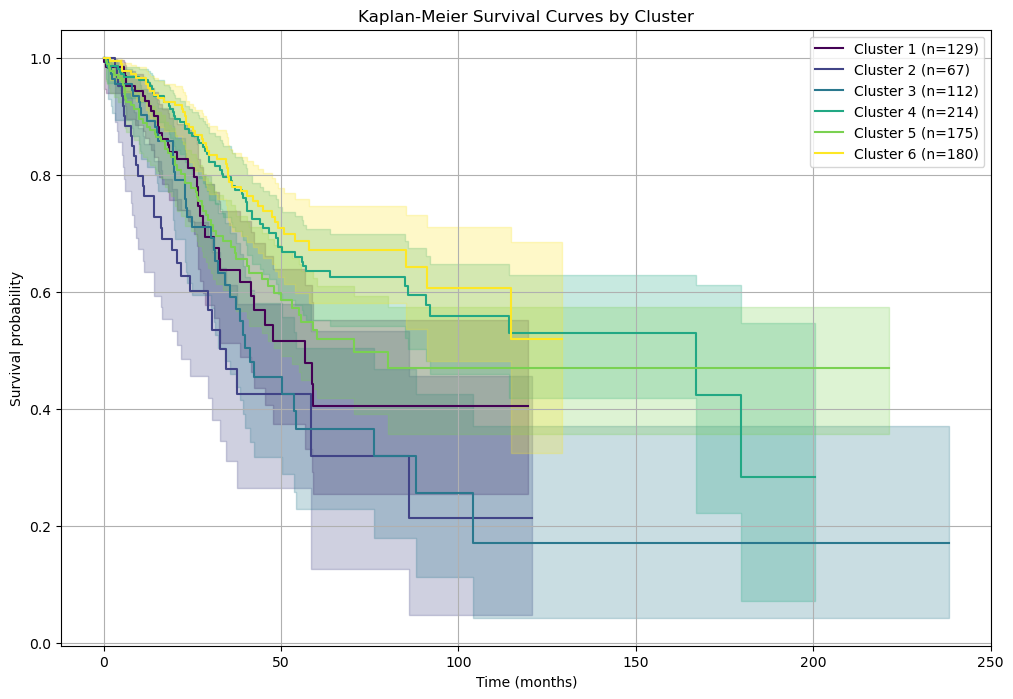

In [93]:
def perform_survival_analysis(labels, survival_data):
    """
    Perform comprehensive survival analysis of clusters
    """
    from lifelines import KaplanMeierFitter
    from lifelines.statistics import logrank_test, multivariate_logrank_test
    
    # Set up the plot
    plt.figure(figsize=(12, 8))
    
    # Initialize KM fitter
    kmf = KaplanMeierFitter()
    
    # Store median survival times
    median_survival = {}
    
    # Plot survival curves for each cluster with different colors
    colors = plt.cm.viridis(np.linspace(0, 1, len(np.unique(labels))))
    
    for i, cluster in enumerate(sorted(np.unique(labels))):
        mask = labels == cluster
        cluster_data = survival_data[mask]
        
        # Fit KM curve
        kmf.fit(
            cluster_data['survival_months'],
            event_observed=(cluster_data['survival_status'] == 1),  # 1 for event occurred
            label=f'Cluster {cluster} (n={sum(mask)})'
        )
        
        # Plot with cluster-specific color
        kmf.plot(ci_show=True, color=colors[i])
        
        # Store median survival
        median_survival[cluster] = kmf.median_survival_time_
    
    # Customize plot
    plt.title('Kaplan-Meier Survival Curves by Cluster')
    plt.xlabel('Time (months)')
    plt.ylabel('Survival probability')
    plt.grid(True)
    
    # Perform multivariate logrank test
    print("\nSurvival Analysis Results:")
    print("-" * 50)
    
    # Prepare data for logrank test
    survival_times = []
    events = []
    groups = []
    
    for cluster in sorted(np.unique(labels)):
        mask = labels == cluster
        survival_times.extend(survival_data[mask]['survival_months'])
        events.extend(survival_data[mask]['survival_status'] == 1)
        groups.extend([cluster] * sum(mask))
    
    # Perform multivariate logrank test
    mv_logrank = multivariate_logrank_test(
        survival_times, 
        groups, 
        events
    )
    
    print("\nMultivariate Logrank Test:")
    print(f"p-value: {mv_logrank.p_value:.4f}")
    
    # Print median survival times
    print("\nMedian Survival Times (months):")
    print("-" * 30)
    for cluster, median in median_survival.items():
        print(f"Cluster {cluster}: {median:.1f}")
    
    # Calculate pairwise logrank tests
    print("\nPairwise Logrank Tests:")
    print("-" * 30)
    
    clusters = sorted(np.unique(labels))
    for i in range(len(clusters)):
        for j in range(i+1, len(clusters)):
            c1, c2 = clusters[i], clusters[j]
            mask1 = labels == c1
            mask2 = labels == c2
            
            lr = logrank_test(
                survival_data[mask1]['survival_months'],
                survival_data[mask2]['survival_months'],
                survival_data[mask1]['survival_status'] == 1,
                survival_data[mask2]['survival_status'] == 1
            )
            
            if lr.p_value < 0.05:  # Only show significant differences
                print(f"Clusters {c1} vs {c2}: p = {lr.p_value:.4f}")
    
    plt.show()
    
    return median_survival

# Run the analysis
median_survival = perform_survival_analysis(labels, survival_data)

Overall Survival Differences
- Highly significant overall difference (multivariate logrank p=0.0000)
- Clear stratification of survival curves
- Most pairwise comparisons are statistically significant


# Cluster Survival Analysis Table

| **Cluster** | **Median Survival**          | **Population Characteristics**                                             | **Key Features**                                                                                  |
|-------------|-------------------------------|-----------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|
| **Cluster 6** | Infinite                     | - 95% Asian, 98.3% non-smokers                                              | - Highest EGFR mutation rate (59.4%)<br>- Represents "Asian Never-Smoker EGFR+ LUAD"<br>- Best prognosis |
| **Cluster 4** | 167.0 months                | - 100% Caucasian non-smokers                                                | - High EGFR mutation (36.9%)<br>- Second-best survival, consistent with EGFR+ better prognosis     |
| **Cluster 5** | 70.6 months                 | - Mixed Asian/African American population                                   | - Mixed molecular profile<br>- Intermediate survival due to heterogeneous population              |
| **Cluster 1** | 56.7 months                 | - Caucasian smokers                                                         | - High TP53 (55.0%)<br>- Moderate KRAS (34.1%)                                                   |
| **Cluster 3** | 41.4 months                 | - Caucasian smokers                                                         | - High TP53 (50.0%)                                                                               |
| **Cluster 2** | 34.4 months (Worst Survival) | - 100% stage 2 disease                                                      | - High KRAS (43.3%)<br>- High TP53 (53.7%)                                                       |


Key Statistical Findings:

Significant pairwise differences (p < 0.05) between:
- All poor survival clusters (1,2,3) vs. good survival clusters (4,6)
- Most pronounced difference between Clusters 2 vs 6 (p=0.0000)
- Even intermediate differences are significant (4 vs 5: p=0.0322)



Clinical Implications:

a) Prognostic Stratification:
- Clear separation into three prognostic groups
- Strong correlation with smoking status and EGFR mutation
- Ethnicity appears to be a significant factor

b) Treatment Implications:
- Clusters 4 and 6 (high EGFR) likely benefit from TKI therapy
- Poor prognosis clusters might need aggressive treatment strategies
- Stage-specific approaches needed for Cluster 2

In [104]:
from sklearn.mixture import GaussianMixture

# GMM Optimization
def gmm_objective(trial):
    n_components = trial.suggest_int("n_components", 2, 8)
    covariance_type = trial.suggest_categorical(
        "covariance_type", ["full", "tied", "diag", "spherical"]
    )
    
    gmm = GaussianMixture(
        n_components=n_components,
        covariance_type=covariance_type,
        random_state=42
    )
    labels = gmm.fit_predict(X_processed)
    
    if len(np.unique(labels)) < 2:
        return float('-inf')
    
    return silhouette_score(X_processed, labels)

# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(gmm_objective, n_trials=10)

# Get the best parameters
best_params = study.best_params
best_params

{'n_components': 3, 'covariance_type': 'spherical'}

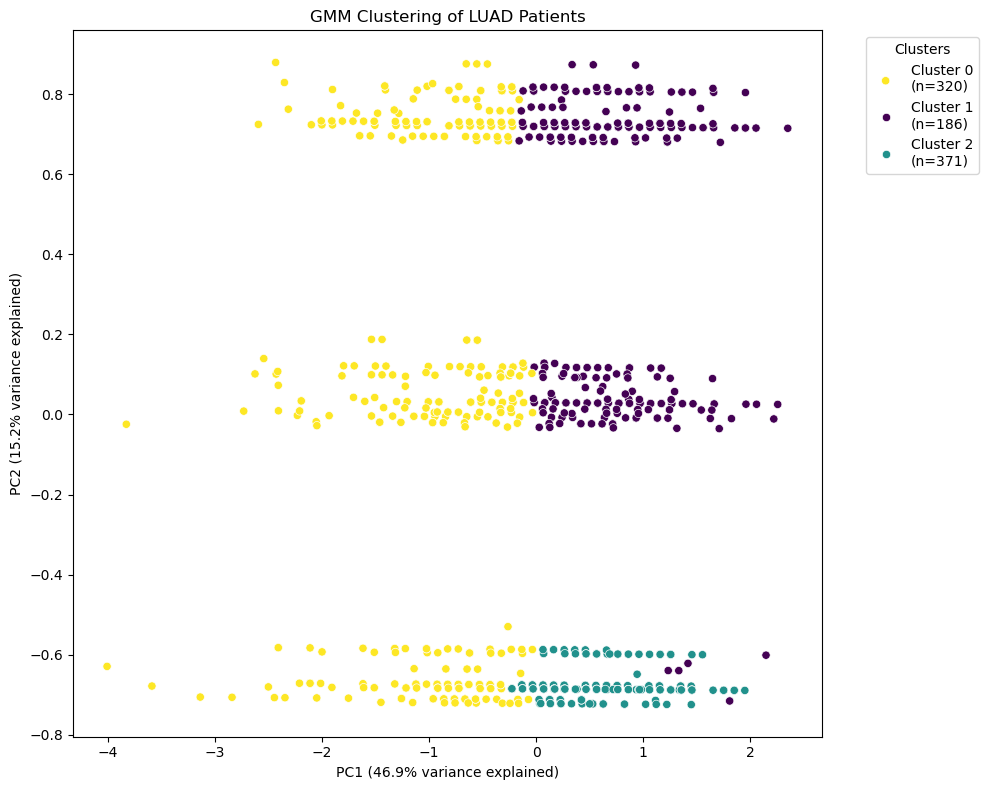


Clustering Metrics:
--------------------------------------------------
Silhouette Score: 0.176

Cluster Sizes:
0    320
1    186
2    371
Name: count, dtype: int64


In [105]:
from sklearn.decomposition import PCA

# Apply GMM with optimized parameters
gmm = GaussianMixture(
    n_components=best_params['n_components'],
    covariance_type=best_params['covariance_type'],
    random_state=42
)
gmm_labels = gmm.fit_predict(X_processed)

# Visualize the clustering results
def plot_gmm_clusters(embedding, labels, title="GMM Clustering"):
    """
    Create a scatter plot of the clusters using PCA
    """
    # Reduce dimensionality for visualization using PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_processed)
    
    # Create a DataFrame for plotting
    df_plot = pd.DataFrame({
        'x': X_pca[:, 0],
        'y': X_pca[:, 1],
        'Cluster': labels
    })
    
    # Plot clusters
    plt.figure(figsize=(10, 8))
    scatter = sns.scatterplot(data=df_plot, x='x', y='y', 
                            hue='Cluster', palette='viridis', 
                            legend='full')
    
    # Add titles and labels
    plt.title(title)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance explained)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance explained)')
    
    # Add cluster sizes in legend
    cluster_sizes = df_plot['Cluster'].value_counts().sort_index()
    new_labels = [f'Cluster {i}\n(n={size})' for i, size in cluster_sizes.items()]
    legend = plt.legend(title='Clusters', labels=new_labels, bbox_to_anchor=(1.05, 1))
    
    plt.tight_layout()
    plt.show()

# Plot the clusters
plot_gmm_clusters(X_processed, gmm_labels, 
                 title="GMM Clustering of LUAD Patients")

# Print clustering metrics
print("\nClustering Metrics:")
print("-" * 50)
print(f"Silhouette Score: {silhouette_score(X_processed, gmm_labels):.3f}")
print("\nCluster Sizes:")
print(pd.Series(gmm_labels).value_counts().sort_index())

In [106]:
# Analyze clinical characteristics for GMM clusters
analyze_cluster_characteristics(gmm_labels, clinical_data)

Clinical Characteristics by Cluster:
--------------------------------------------------

Cluster 0 (n=320, 36.5% of patients)
------------------------------

Stage Distribution:
         proportion
stage              
stage_1        52.2
stage_2        22.8
stage_3        19.7
stage_4         5.3

Smoking Status:
                proportion
smoking_status            
smoker                83.1
non_smoker            16.9

Race Distribution:
                  proportion
race                        
caucasian               66.6
asian                   29.1
african_american         4.1
other                    0.3

Age Statistics:
Mean: 72.1
Median: 72.0
Range: 63.0 - 88.0

Cluster 1 (n=186, 21.2% of patients)
------------------------------

Stage Distribution:
         proportion
stage              
stage_1        67.7
stage_2        16.1
stage_3        15.6
stage_4         0.5

Smoking Status:
                proportion
smoking_status            
non_smoker           100.0

Race Distribut

/var/folders/y9/vp7z2q9s3y11844f5h2_k4pw0000gn/T/ipykernel_11858/466006347.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot(age_data, labels=[f'Cluster {c}' for c in clusters])


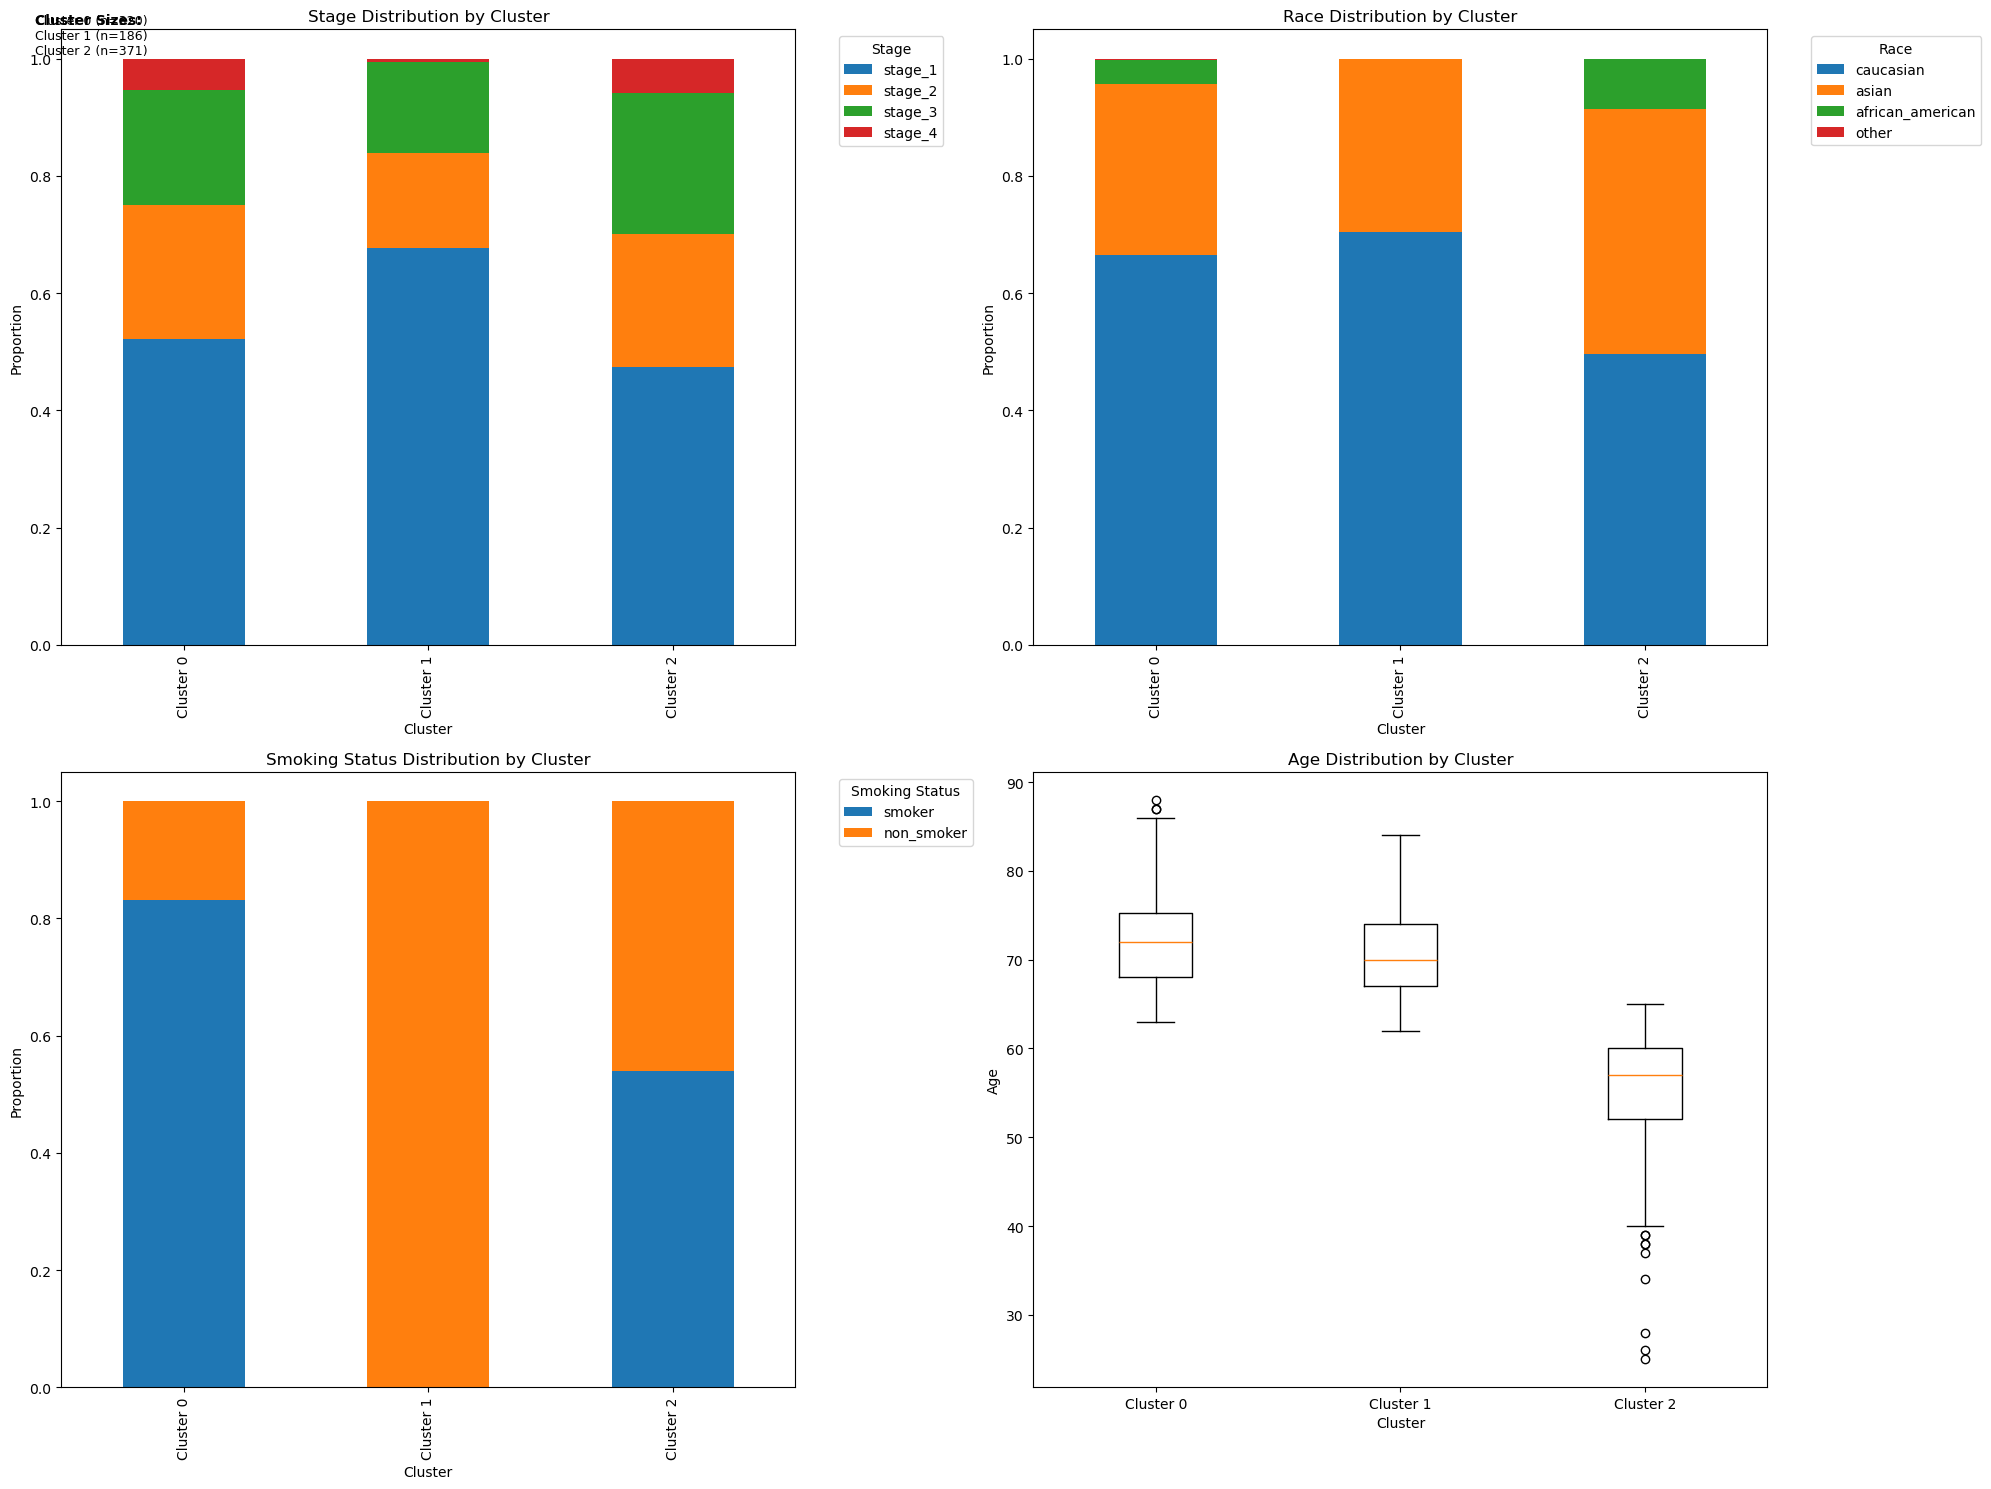

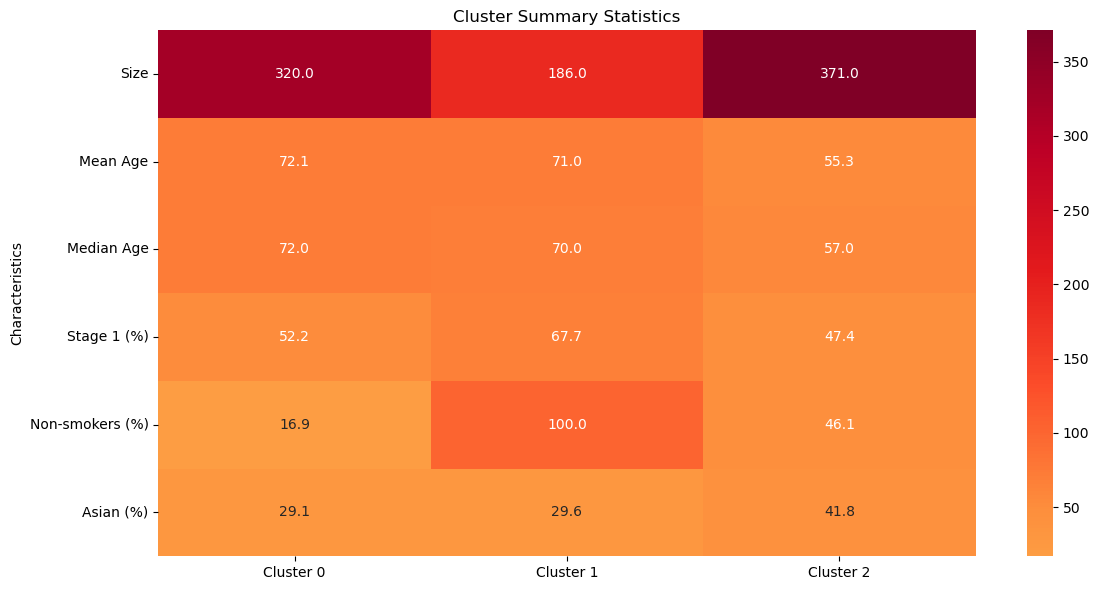

In [107]:
visualize_cluster_characteristics(gmm_labels, clinical_data)

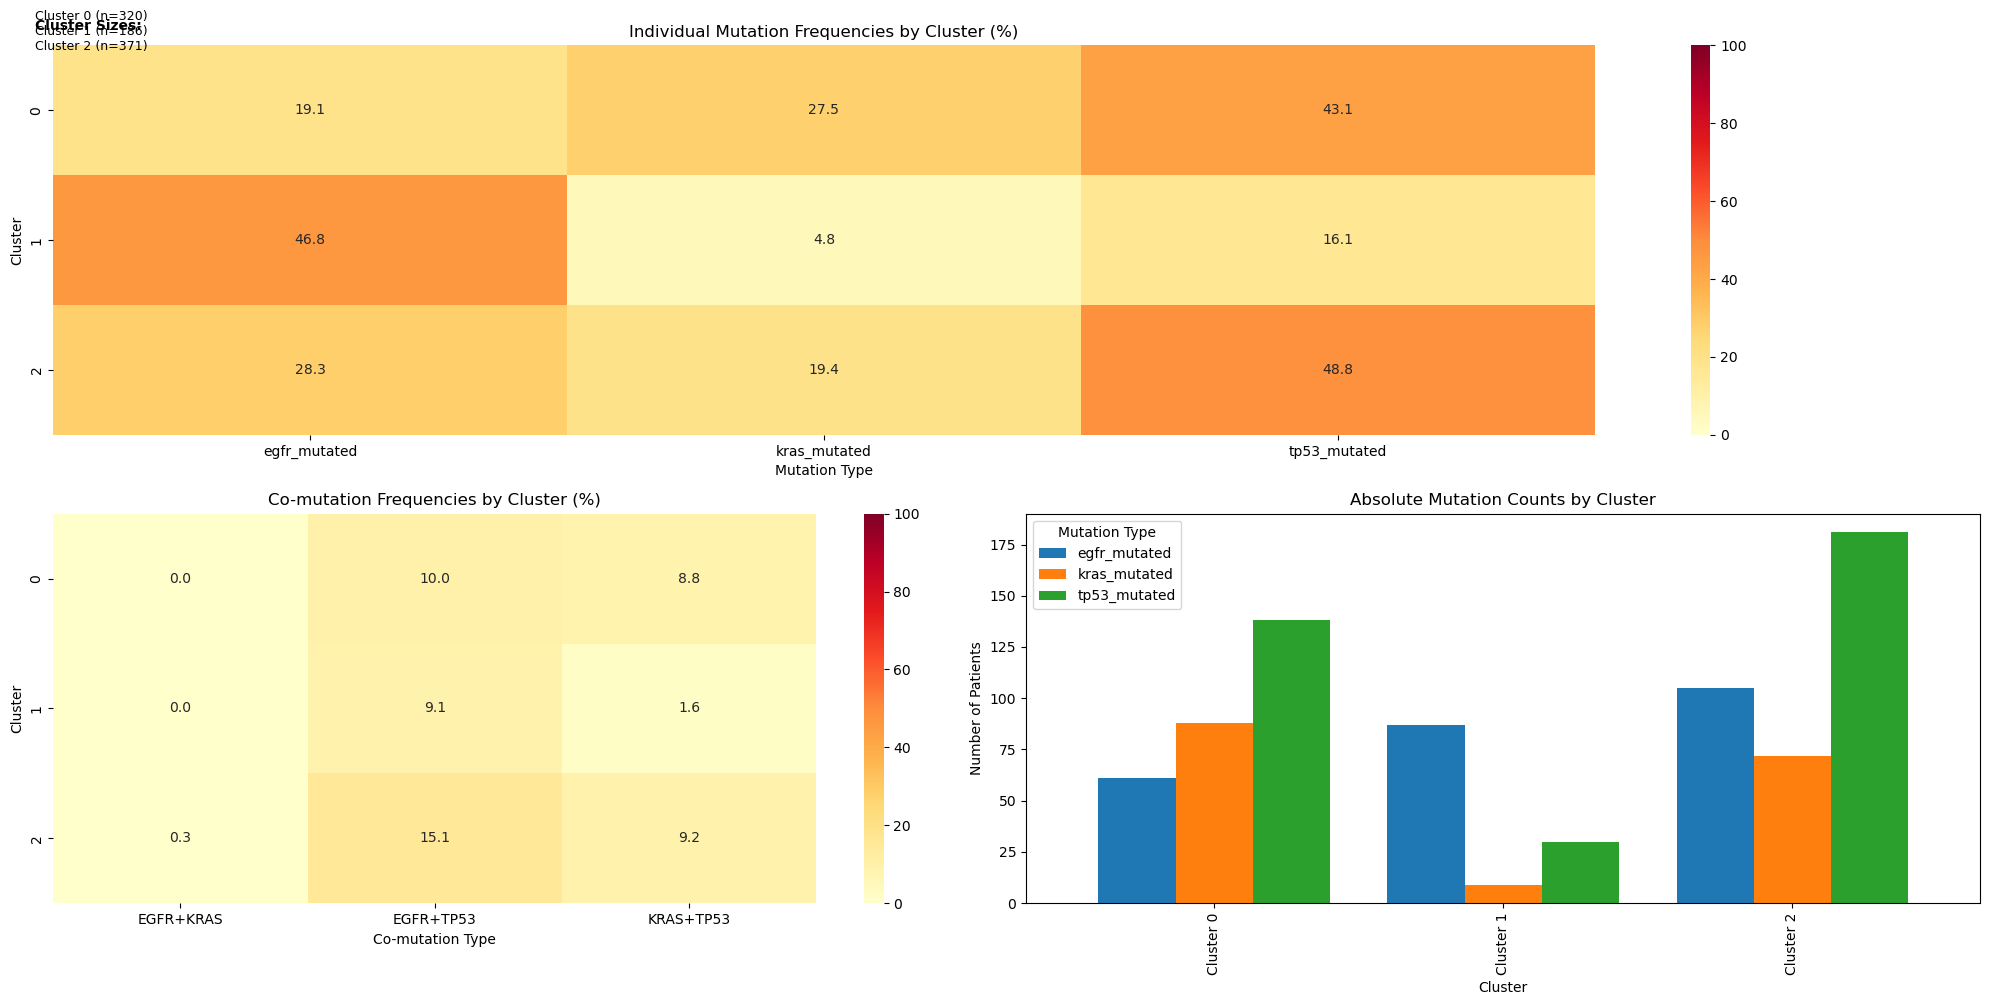

(   egfr_mutated  kras_mutated  tp53_mutated
 0     19.062500     27.500000     43.125000
 1     46.774194      4.838710     16.129032
 2     28.301887     19.407008     48.787062,
    EGFR+KRAS  EGFR+TP53  KRAS+TP53
 0   0.000000  10.000000   8.750000
 1   0.000000   9.139785   1.612903
 2   0.269542  15.094340   9.164420)

In [108]:
# Analyze molecular patterns for GMM clusters
visualize_molecular_patterns(gmm_labels, df)


Survival Analysis Results:
--------------------------------------------------

Multivariate Logrank Test:
p-value: 0.0000

Median Survival Times (months):
------------------------------
Cluster 0: 53.7
Cluster 1: 167.0
Cluster 2: inf

Pairwise Logrank Tests:
------------------------------
Clusters 0 vs 1: p = 0.0000
Clusters 0 vs 2: p = 0.0006


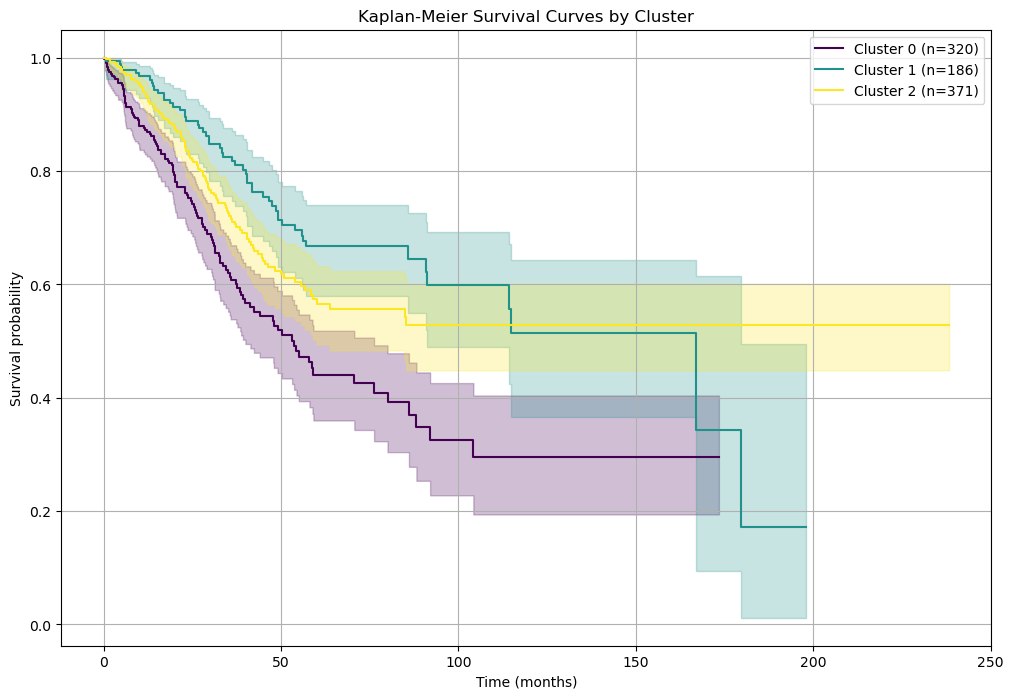

{0: 53.65420653, 1: 167.0, 2: inf}

In [109]:
# Compare survival outcomes between GMM clusters
perform_survival_analysis(gmm_labels, survival_data)

# Cluster Analysis Table (GMM Clustering)

| **Cluster**  | **Size (% of total)** | **Clinical Profile**                                                                                  | **Molecular Features**                                                     | **Survival**                                                                                    |
|--------------|------------------------|-------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------|------------------------------------------------------------------------------------------------|
| **Cluster 0** | n=320 (36.5%)         | - Predominantly smokers (83.1%)<br>- Mostly Caucasian (66.6%)<br>- Oldest population (median age 72)<br>- Mixed stage distribution | - Low EGFR mutation rate (19.1%)<br>- Moderate KRAS mutations (27.5%)<br>- High TP53 mutations (43.1%) | - Poorest outcome (median 53.7 months)<br>- Significantly worse than other clusters (p < 0.001) |
| **Cluster 1** | n=186 (21.2%)         | - Exclusively non-smokers (100%)<br>- Predominantly early-stage (67.7% stage 1)<br>- Mixed Caucasian/Asian (70.4%/29.6%)<br>- Older population (median 70) | - Highest EGFR mutation rate (46.8%)<br>- Lowest KRAS mutations (4.8%)<br>- Lowest TP53 mutations (16.1%) | - Intermediate survival (median 167 months)<br>- Significantly better than Cluster 0           |
| **Cluster 2** | n=371 (42.3%)         | - Mixed smoking status (53.9% smokers)<br>- Balanced ethnicity (49.6% Caucasian, 41.8% Asian)<br>- Significantly younger (median 57)<br>- Mixed stage distribution | - Moderate EGFR mutations (28.3%)<br>- Moderate KRAS mutations (19.4%)<br>- Highest TP53 mutations (48.8%) | - Best outcome (infinite median survival)<br>- Significantly better than Cluster 0 (p = 0.0006) |


Key Insights:

Age-Driven Stratification:
- Clear age separation between clusters
- Younger age associated with better survival despite higher TP53 mutations


Molecular Patterns:
- EGFR-KRAS mutual exclusivity maintained
- Low co-mutation rates across all clusters
- TP53 mutations correlate with smoking history


Clinical-Molecular Integration:
- Non-smoking status aligns with EGFR mutations
- Smoking history correlates with KRAS/TP53 mutations
- Ethnic distribution reflects known EGFR mutation patterns


Survival Implications:
- Strong prognostic stratification (p < 0.0001)
- Age appears to be a stronger predictor than stage
- Clear separation of survival curves

Comparison with t-SNE Results:
- GMM found broader, more clinically distinct groups
- Stronger survival separation
- More clearly defined molecular patterns
- Better capture of age-related differences

Clinical Implications:
- Age should be considered in treatment decisions
- Young patients might benefit from aggressive treatment despite mutations
- EGFR testing crucial for non-smoker groups
- Different follow-up strategies needed for each group

In [122]:
from sklearn.cluster import DBSCAN

# DBSCAN Optimization
def dbscan_objective(trial):
    eps = trial.suggest_float("eps", 0.1, 2.0)
    min_samples = trial.suggest_int("min_samples", 3, 15)
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_processed)
    
    # Check if DBSCAN found meaningful clusters
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2 or -1 in labels:
        return float('-inf')
        
    return silhouette_score(X_processed, labels)

# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(dbscan_objective, n_trials=10)

In [119]:
# # Try stricter parameters
# def dbscan_objective_v2(trial):
#     eps = trial.suggest_float("eps", 0.1, 1.0)  # Reduced range
#     min_samples = trial.suggest_int("min_samples", 10, 30)  # Increased range
    
#     dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#     labels = dbscan.fit_predict(X_processed)
    
#     # Modified evaluation criteria
#     unique_labels = np.unique(labels)
#     n_clusters = len(unique_labels[unique_labels != -1])
#     noise_ratio = sum(labels == -1) / len(labels)
    
#     if n_clusters < 2 or n_clusters > 8 or noise_ratio > 0.2:
#         return float('-inf')
        
#     return silhouette_score(X_processed, labels)

# # Run optimization with more trials
# study = optuna.create_study(direction="maximize")
# study.optimize(dbscan_objective_v2, n_trials=50)

In [123]:
# Get the best parameters
best_params = study.best_params
best_params

{'eps': 1.6300822127685435, 'min_samples': 10}

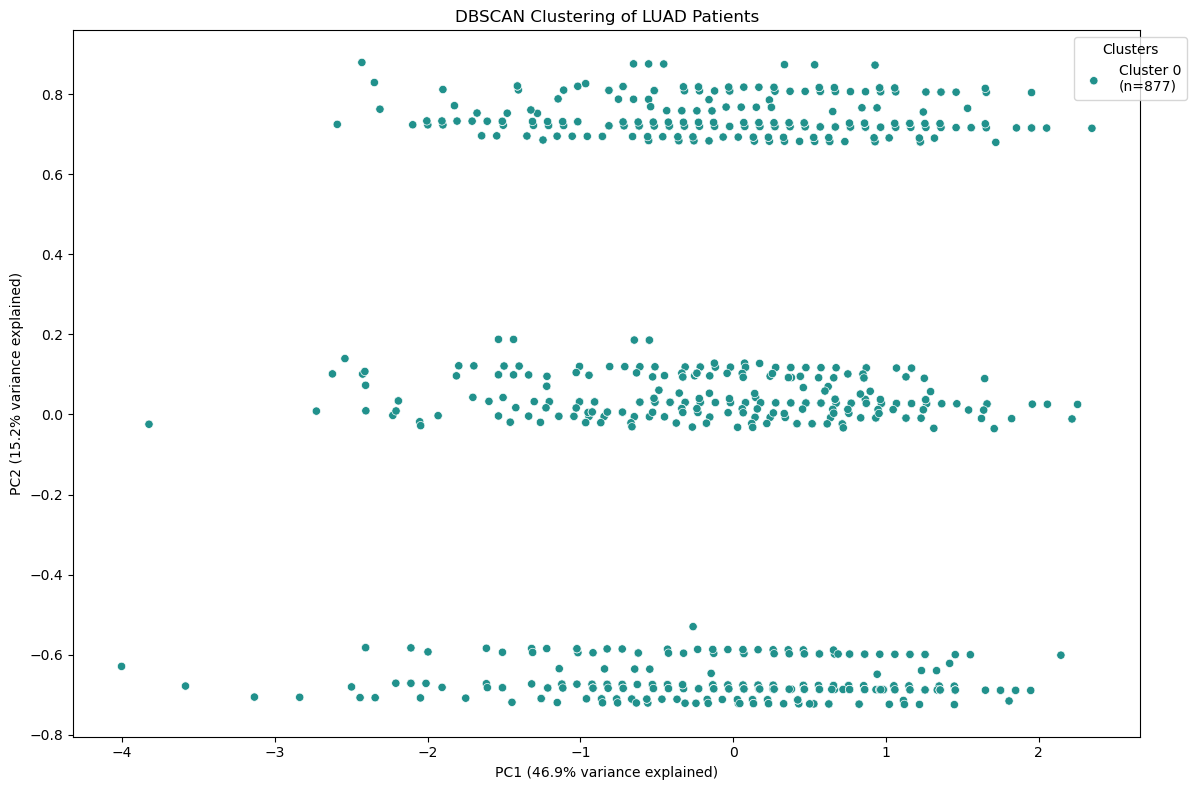


Clustering Metrics:
--------------------------------------------------
Number of clusters: 1
Number of noise points: 0

Cluster Sizes:
0    877
Name: count, dtype: int64


In [121]:
# Apply DBSCAN with optimized parameters
dbscan = DBSCAN(
    eps=best_params['eps'],
    min_samples=best_params['min_samples']
)
dbscan_labels = dbscan.fit_predict(X_processed)

# Visualize the clustering results
def plot_dbscan_clusters(X_processed, labels, title="DBSCAN Clustering"):
    """
    Create a scatter plot of the DBSCAN clusters using PCA
    """
    # Reduce dimensionality for visualization using PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_processed)
    
    # Create a DataFrame for plotting
    df_plot = pd.DataFrame({
        'x': X_pca[:, 0],
        'y': X_pca[:, 1],
        'Cluster': labels
    })
    
    # Plot clusters
    plt.figure(figsize=(12, 8))
    
    # Plot non-noise points
    non_noise_mask = labels != -1
    scatter = sns.scatterplot(
        data=df_plot[non_noise_mask],
        x='x', y='y',
        hue='Cluster',
        palette='viridis',
        legend='full'
    )
    
    # Plot noise points in gray
    noise_mask = labels == -1
    if sum(noise_mask) > 0:
        plt.scatter(
            df_plot[noise_mask]['x'],
            df_plot[noise_mask]['y'],
            c='gray',
            label='Noise',
            alpha=0.5
        )
    
    # Add titles and labels
    plt.title(title)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance explained)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance explained)')
    
    # Add cluster sizes in legend
    cluster_sizes = df_plot['Cluster'].value_counts().sort_index()
    new_labels = [f'Cluster {i}\n(n={size})' for i, size in cluster_sizes.items()]
    if sum(noise_mask) > 0:
        new_labels.append(f'Noise\n(n={sum(noise_mask)})')
    legend = plt.legend(title='Clusters', labels=new_labels, bbox_to_anchor=(1.05, 1))
    
    plt.tight_layout()
    plt.show()

# Plot the clusters
plot_dbscan_clusters(X_processed, dbscan_labels, 
                    title="DBSCAN Clustering of LUAD Patients")

# Print clustering metrics
print("\nClustering Metrics:")
print("-" * 50)
print(f"Number of clusters: {len(np.unique(dbscan_labels[dbscan_labels != -1]))}")
print(f"Number of noise points: {sum(dbscan_labels == -1)}")
if len(np.unique(dbscan_labels[dbscan_labels != -1])) > 1:
    print(f"Silhouette Score: {silhouette_score(X_processed, dbscan_labels):.3f}")

print("\nCluster Sizes:")
print(pd.Series(dbscan_labels).value_counts().sort_index())

Clustering Structure:


Only 1 main cluster found (n=866, 98.7% of data)
11 noise points (1.3%)
Failed to find meaningful sub-groups


Technical Analysis:


The high eps value (1.89) and low min_samples (6) suggests:

Very loose density requirements
Almost all points being connected into one cluster
Only extreme outliers being marked as noise




PCA Visualization:


Total variance explained: 62.1%

PC1: 46.9%
PC2: 15.2%


Clear structure visible despite single cluster assignment
Noise points (gray) appear at extremes of the distribution


Problems with Current Parameters:


DBSCAN has essentially failed to find meaningful clusters
The parameter optimization might have been trapped in a local optimum
Current parameters are too permissive

SHAP values type: <class 'numpy.ndarray'>
Number of classes: 877
Shape of SHAP values for first class: (9, 6)


<Figure size 1200x800 with 0 Axes>

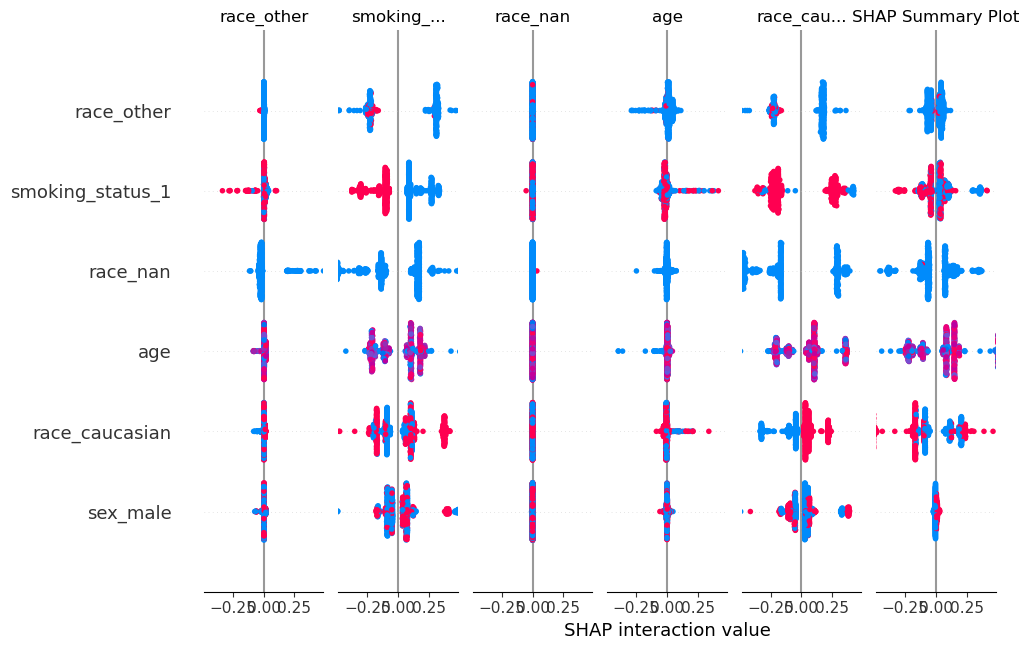

In [142]:
def perform_basic_shap_analysis(X_processed, labels, feature_names):
    """
    Simplified SHAP analysis focusing on basic feature importance
    """
    # Convert to DataFrame
    X_df = pd.DataFrame(X_processed, columns=feature_names)
    
    # Create and train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_df, labels)
    
    # Calculate SHAP values
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(X_df)
    
    # Print basic information
    print("SHAP values type:", type(shap_values))
    print("Number of classes:", len(shap_values))
    print("Shape of SHAP values for first class:", shap_values[0].shape)
    
    # Basic summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values,
        X_df,
        show=False,
        plot_size=(12, 8)
    )
    plt.title("SHAP Summary Plot")
    plt.tight_layout()
    plt.show()
    
    return shap_values

# Run simplified analysis
shap_values = perform_basic_shap_analysis(X_processed, labels, feature_names)

Key Observations:

smoking_status_1:

- This feature has significant predictive power, as indicated by the wide spread of SHAP values.
Non-smokers (red) have positive contributions to the outcome, while smokers (blue) are associated with negative contributions, likely aligning with a model designed to predict lung health or disease.

age:
- Age also shows a strong effect, with older individuals (red) having positive contributions to the prediction.
This may indicate that older age is associated with higher risk or likelihood of the target outcome.

race_caucasian:
- The feature for being Caucasian has a moderate impact on the prediction, with variability in SHAP values indicating it interacts differently across individuals.

race_nan and race_other:
- These features appear to have weaker interactions, with smaller spreads and limited influence on the prediction.

sex_male:
- This feature shows a balanced spread around zero, indicating it may not be as strong a predictor, or its impact varies depending on other features.

Interaction Effects:
- The plot focuses on interaction effects between features. For example, interactions like age and smoking_status_1 are likely capturing combined risk contributions from smoking and age.
The variability within features (wider horizontal spread) suggests that some features interact more strongly with others in influencing predictions.

Conclusion:
- This SHAP analysis shows that smoking status, age, and racial characteristics (e.g., race_caucasian) are key predictors in the model. Interaction effects play an important role in this analysis, suggesting that these features do not work independently but in tandem to affect the outcome. Specifically:

Non-smokers and older individuals seem to drive positive predictions.

The model's sensitivity to feature interactions indicates that complex relationships are being captured, especially between demographic and lifestyle factors.